# Preprocesamiento

In [7]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt


# Mostrar todas las filas y columnas en outputs
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

df = pd.read_excel("datos_tarea25.xlsx")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Analísis y depuración de los datos. 
Lo primero que haremos será formalizar nuestro DataFrame para poder ser utilizado, para ello realizaremos los siguientes peuqños cambios:
* Detectaremos todas las variables dicotomicas y las convertiremos en 0 y 1
* Quitaremos el string "km" de toda la columna de "Mileage"
* En la columna "Engine volume", algunos coches tienen "Turbo" en su motor, para poder utilizar bien esta variable y no perder los datos sobre aquellos coches que tienen turbo, he eleiminado el string "Turbo" y he creado una variable dicotomica para todas aquellas observaciones que tienen "Turbo".
* En la variable "Levy" he eliminado los valores de "-" y he imputado **joafodjjfa**


In [8]:
from Pyurification import Pyurification

pyrf = Pyurification(df)

pyrf.change_to_num(["Levy", "Prod. year", "Engine volume", "Airbags"])
pyrf.remove_string_from_num("Mileage")
pyrf.create_and_remove_string_from_num("Engine volume")
pyrf.change_value_in_col("Levy", ["-"], changed_values=0)
pyrf.onehotencoder(["Manufacturer", "Category", "Fuel type", "Drive wheels"])

c:\Users\Usuario\Desktop\Ejercicios de uni\Machine learning tarea 1\Pyurification.py:116: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return series.replace({val_unicos[0]:0, val_unicos[1]:1})


In [9]:
X = pyrf.df


y = X["Color"]
X.drop(columns="Color", inplace=True)

## División de los datos 

In [10]:
from sklearn.model_selection import train_test_split

test_size = 0.2
random_state = 777

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
print(f"La frecuencia de cada clase en train es: \n{y_train.value_counts(normalize=True)}")
print(f"La frecuencia de cada clase en test es: \n{y_test.value_counts(normalize=True)}")

La frecuencia de cada clase en train es: 
Color
0    0.531394
1    0.468606
Name: proportion, dtype: float64
La frecuencia de cada clase en test es: 
Color
0    0.5553
1    0.4447
Name: proportion, dtype: float64


# Árbol de clasificación
## Busqueda paramétrica del mejor árbol

In [24]:
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score

from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree

# Tuneo
params={
    "max_depth":[2, 3, 5, 10, 20],
    "min_samples_split":[5, 10, 20, 50, 100],
    "criterion": ["gini", "entropy"]
}
scoring_metrics = ["accuracy", "precision_macro", "recall_macro", "f1_macro"]


#Cross Validation
decision_tree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator=decision_tree,
                           param_grid=params,
                           cv=4,
                           scoring=scoring_metrics,
                           refit="accuracy")
grid_search.fit(X_train, y_train)


# Obtenemos los resultados del grid search.
result = pd.DataFrame(grid_search.cv_results_)

result.sort_values(by="mean_test_accuracy", ascending=False, inplace=True)
result[["params", "mean_test_accuracy", "mean_test_precision_macro", "mean_test_recall_macro", "mean_test_f1_macro"]].head(5)


,params,mean_test_accuracy,mean_test_precision_macro,mean_test_recall_macro,mean_test_f1_macro
45,"{'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 5}",0.752304,0.752310,0.750872,0.750920
20,"{'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 5}",0.747696,0.747181,0.745595,0.746013
21,"{'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 10}",0.745968,0.745775,0.743646,0.744062
15,"{'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 5}",0.742800,0.742089,0.740842,0.741180
46,"{'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 10}",0.741935,0.742041,0.740528,0.740465


In [22]:
# Usaremos unos cuantos modelo
res_1=result[["split0_test_accuracy", "split1_test_accuracy", "split2_test_accuracy", "split3_test_accuracy",]].iloc[0]
res_2=result[["split0_test_accuracy", "split1_test_accuracy", "split2_test_accuracy", "split3_test_accuracy",]].iloc[1]
res_3=result[["split0_test_accuracy", "split1_test_accuracy", "split2_test_accuracy", "split3_test_accuracy",]].iloc[2]


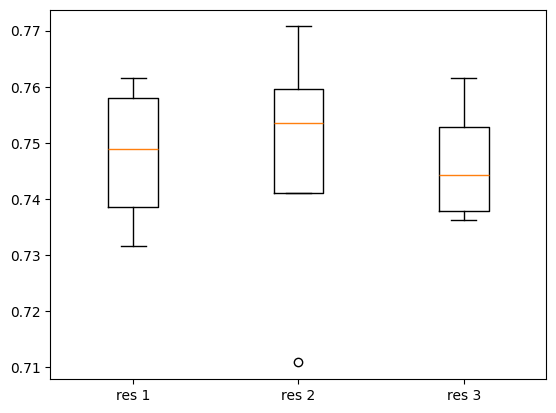

In [23]:
# Creamos una boxplot para los valores de accuracy
# Es importante recordar que los boxplots con gran amplitud son malos porque no tiene robustez
plt.boxplot([res_1.values, res_2.values, res_3.values], labels=["res 1", "res 2", "res 3"])
plt.show()

Finalmente nos quedaremos con el modelo del resultado 2

In [25]:
mejor_modelo = result.iloc[1]["params"]

In [26]:
# Empezamos a predecir
mejor_arbol = DecisionTreeClassifier(**mejor_modelo)
mejor_arbol.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=20, min_samples_split=5)

In [27]:
# Predicciones en train y test
y_train_predict = mejor_arbol.predict(X_train)
y_test_predict = mejor_arbol.predict(X_test)

# Medidas de bondad de ajuste en train
conf_matrix = confusion_matrix(y_train, y_train_predict)
print(conf_matrix)
print("Medidas de desempeño")
print(classification_report(y_train, y_train_predict))


[[1809   36]
 [  93 1534]]
Medidas de desempeño
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1845
           1       0.98      0.94      0.96      1627

    accuracy                           0.96      3472
   macro avg       0.96      0.96      0.96      3472
weighted avg       0.96      0.96      0.96      3472



Area bajo la curva ROC 1.00


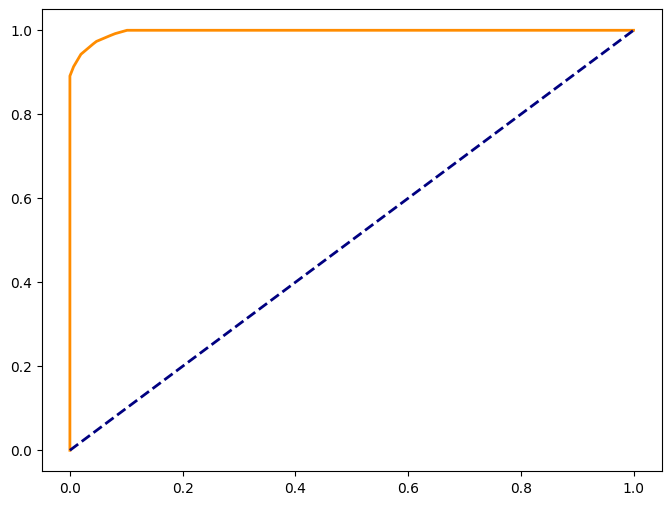

In [28]:
# Curvas ROC
y_train_auc = pd.get_dummies(y_train, drop_first=True)

# Calcular el area bajo la curva ROC
y_prob_train = mejor_arbol.predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train_auc, y_prob_train)
roc_auc = (auc(fpr, tpr))
print(f"Area bajo la curva ROC {roc_auc:.2f}")

# Graficar la curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0,1], color="navy", lw=2, linestyle="--")
plt.show()

# Random Forest